In [1]:
%%bash
head data/treebank/treebank_sent.txt
echo "=================================================================="
head data/treebank/treebank_pos.txt

Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .
Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .
Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .
A form of asbestos once used to make Kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than 30 years ago , researchers reported .
The asbestos fiber , crocidolite , is unusually resilient once it enters the lungs , with even brief exposures to it causing symptoms that show up decades later , researchers said .
Lorillard Inc. , the unit of New York-based Loews Corp. that makes Kent cigarettes , stopped using crocidolite in its Micronite cigarette filters in 1956 .
Although preliminary findings were reported more than a year ago , the latest results appear in today 's New England Journal of Medicine , a forum like

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

import nltk
import collections
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
np.random.seed(87)

In [3]:
sent_file = "data/treebank/treebank_sent.txt"
pos_file = "data/treebank/treebank_pos.txt"

embed_dim = 300  # embedding layer에서 사용할 feature의 수
hidden_dim = 256  # GRU 마지막 결과값이 전달될 fully-connected layer의 노드 갯수
batch_size = 64  # 한 번에 처리할 데이터의 수
num_epoch = 2# 전체 데이터를 반복할 횟수
learning_rate = 0.001
max_gradient_norm = 5

In [4]:
def parse_sentence(filename):
    counter = collections.Counter()
    max_len = 0
    num_sent = 0
    
    with open(filename, "r") as f:
        for line in f:
            words = line.strip().lower().split()

            # get frequency
            for word in words:
                counter[word] += 1

            # get max_len
            if len(words) > max_len:
                max_len = len(words)

            # get num_sent
            num_sent += 1

        f.close()
    return counter, max_len, num_sent

sent_counter, sent_max_len, sent_num_sent = parse_sentence(sent_file)
pos_counter, pos_max_len, pos_num_sent = parse_sentence(pos_file)

print("Sentence Info")
print("\tNumber of words: ", len(sent_counter))
print("\tMaximum length: ", sent_max_len)
print("\tNumber of sents: ", sent_num_sent)
print("=" * 40)
print("POS Info")
print("\tNumber of POS: ", len(pos_counter))
print("\tMaximum length: ", pos_max_len)
print("\tNumber of sents: ", pos_num_sent)        

Sentence Info
	Number of words:  10947
	Maximum length:  249
	Number of sents:  3914
POS Info
	Number of POS:  45
	Maximum length:  249
	Number of sents:  3914


In [5]:
seq_len = 250
num_vocab = 10947
num_pos = 45

In [6]:
def create_dictionary(counter_name, max_num, sentence = False):
    # tmp_word2idx = collections.defaultdict(int)
    if sentence:
        tmp_word2idx = {x[0]: i + 2 for i, x in enumerate(counter_name.most_common(max_num))}
        tmp_word2idx["PAD"] = 0
        tmp_word2idx["UNK"] = 1
        tmp_word2idx["EOS"] = max_num + 2
    else:
        tmp_word2idx = {x[0]: i + 1 for i, x in enumerate(counter_name.most_common(max_num))}
        tmp_word2idx["PAD"] = 0
        tmp_word2idx["EOS"] = max_num + 1
    tmp_idx2word = {v: k for k, v in tmp_word2idx.items()}
    
    return tmp_word2idx, tmp_idx2word

sent_word2idx, sent_idx2word = create_dictionary(sent_counter, num_vocab, sentence = True)
pos_word2idx, pos_idx2word = create_dictionary(pos_counter, num_pos)

print(sent_idx2word[0], sent_idx2word[1])
print(pos_idx2word[0])

print(sent_word2idx["EOS"], sent_idx2word[sent_word2idx["EOS"]])
print(pos_word2idx["nnp"], pos_idx2word[pos_word2idx["nnp"]])

sent_num_vocab = num_vocab + 3
pos_num_pos = num_pos + 2

PAD UNK
PAD
10949 EOS
3 nnp


In [7]:
def build_tensor(filename, num_sent, word2idx, max_len, category = False):
    data = []
    with open(filename, "r") as f:
        sent_num = 0
        for line in f:
            wids = []
            line = line.lower()
            for word in line.strip().split():
                try:
                    wids.append(word2idx[word])
                except KeyError:
                    wids.append(word2idx["UNK"])
            #if category:
            #    data[sent_num] = np_utils.to_categorical(wids, num_classes=len(word2idx))
                # print(line)
                # print(data[sent_num])
            #else:
            # data[sent_num] = wids
            data.append(wids)
            sent_num += 1
        f.close()
    
    # tensor_data = sequence.pad_sequences(data, maxlen = max_len, padding = "post")
    #if category:
    #    tensor_data = np_utils.to_categorical(tensor_data, num_classes=len(word2idx))
    return data

X_data = build_tensor(sent_file, sent_num_sent, sent_word2idx, seq_len)
y_data = build_tensor(pos_file, pos_num_sent, pos_word2idx, seq_len, category = True)
# print(X_data.shape, y_data.shape)
print(X_data[0])
print(y_data[0])

print(sent_word2idx["government"], sent_idx2word[sent_word2idx["government"]])

print("the first word of the first sentence: ", sent_idx2word[X_data[0][1]])
print("POS of that word: ", pos_idx2word[y_data[0][1]])

[7634, 4064, 2, 2113, 79, 319, 2, 40, 2504, 3, 124, 23, 7, 2062, 317, 458, 2107, 4]
[3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8]
104 government
the first word of the first sentence:  vinken
POS of that word:  nnp


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)

In [13]:
def get_length(array_name):
    seq_length = []
    for i in array_name:
        seq_len = np.count_nonzero(i)
        seq_length.append(seq_len)
    return seq_length
train_enc_inp_length = np.array(get_length(X_train))
train_dec_inp_length = np.array(get_length(y_train))

test_enc_inp_length = np.array(get_length(X_test))
test_dec_inp_length = np.array(get_length(y_test))

In [14]:
def getBatch(enc_in, dec_in, dec_out, enc_len, dec_len, batch_size, n_batch, data_size, sentence_length):
    size = min(batch_size, data_size - (n_batch * batch_size) - 1)
    encoder_in = np.zeros([size, sentence_length])
    decoder_in = np.zeros([size, sentence_length])
    decoder_out = np.zeros([size, sentence_length])
    encoder_len = []
    decoder_len = []
    for i in range(0, size):
        j = (n_batch * batch_size) + i
        encoder_in[i] = enc_in[j]
        decoder_in[i] = dec_in[j]
        decoder_out[i] = dec_out[j]
        encoder_len.append(enc_len[j])
        decoder_len.append(dec_len[j])
    return encoder_in, decoder_in, decoder_out, encoder_len, decoder_len

In [15]:
## Original code from: https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/helpers.py
def batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths

# print(X_data.shape)
Xdata, xlen = batch(X_data)
ydata, ylen = batch(y_data)
print(X_data[:10])
print(Xdata[:10])
print(xlen[:10])

[[7634, 4064, 2, 2113, 79, 319, 2, 40, 2504, 3, 124, 23, 7, 2062, 317, 458, 2107, 4], [27, 4064, 16, 169, 5, 7643, 3367, 2, 3, 3676, 661, 138, 4], [3009, 9717, 2, 1216, 79, 319, 9, 606, 169, 5, 4918, 1077, 883, 933, 2, 29, 488, 7, 2062, 317, 5, 45, 1101, 422, 3287, 4], [7, 629, 5, 1072, 660, 314, 6, 122, 1460, 2555, 1720, 32, 951, 7, 184, 1051, 5, 1247, 1875, 227, 7, 138, 5, 505, 4229, 6, 18, 51, 55, 203, 79, 271, 2, 801, 273, 4], [3, 1072, 7619, 2, 2381, 2, 16, 3777, 9394, 660, 18, 2855, 3, 6464, 2, 24, 115, 2043, 3376, 6, 18, 2346, 9059, 12, 830, 64, 3228, 808, 2, 801, 17, 4], [2150, 95, 2, 3, 289, 5, 34, 2374, 10066, 77, 12, 1038, 1460, 1824, 2, 1620, 709, 2381, 8, 31, 5790, 2555, 1720, 8, 3975, 4], [395, 1745, 1451, 52, 273, 51, 55, 7, 48, 271, 2, 3, 504, 514, 2399, 8, 381, 10, 34, 479, 1037, 5, 1237, 2, 7, 3838, 528, 6, 1296, 34, 1431, 6, 3, 352, 4], [7, 2150, 8167, 17, 2, 14, 45, 16, 33, 319, 1610, 4], [97, 364, 2411, 49, 79, 271, 192, 1935, 2779, 5, 1072, 970, 85, 3061, 8201, 4]

In [16]:
PAD = 0
sent_EOS = sent_num_vocab - 1
pos_EOS = pos_num_pos - 1

tf.reset_default_graph()
sess = tf.Session()

encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'encoder_inputs')
decoder_targets = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'decoder_targets')

decoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'decoder_inputs')

In [18]:
embeddings = tf.Variable(tf.random_uniform([sent_num_vocab, embed_dim], -1.0, 1.0), dtype = tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [19]:
encoder_cell = tf.contrib.rnn.LSTMCell(hidden_dim)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_inputs_embedded, 
                                                        dtype = tf.float32, time_major = True)

In [20]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 256) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 256) dtype=float32>)

In [21]:
decoder_cell = tf.contrib.rnn.LSTMCell(hidden_dim)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, decoder_inputs_embedded,
                                                        initial_state = encoder_final_state,
                                                        dtype = tf.float32, time_major=True, 
                                                        scope = "plain_decoder")

In [22]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, pos_num_pos)

decoder_prediction = tf.argmax(decoder_logits, 2)

In [23]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 47) dtype=float32>

In [24]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels = tf.one_hot(decoder_targets, depth = pos_num_pos, dtype = tf.float32), 
    logits = decoder_logits)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [25]:
sess.run(tf.global_variables_initializer())

In [26]:
def getBatch(enc_in, dec_in, batch_size, n_batch, data_size, sentence_length):
    size = min(batch_size, data_size - (n_batch * batch_size) - 1)
    # encoder_in = np.zeros([size, sentence_length])
    # decoder_in = np.zeros([size, sentence_length])
    
    encoder_in = []
    decoder_in = []
    for i in range(0, size):
        j = (n_batch * batch_size) + i
        # encoder_in[i] = enc_in[j]
        # decoder_in[i] = dec_in[j]
        encoder_in.append(enc_in[j])
        decoder_in.append(dec_in[j])
    encoder_inputs_, _ = batch(encoder_in)
    decoder_targets_, _ = batch(
        [(sequence) + [pos_EOS] for sequence in decoder_in]
    )
    decoder_inputs_, _ = batch(
        [[pos_EOS] + (sequence) for sequence in decoder_in]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [27]:
loss_track = []

try:
    print("learning start!")
    data_size = len(X_data)
    n_batch = int((data_size - 1) / batch_size)
    
    for epoch in range(10):
        epoch_loss = []
        for n in range(n_batch):
            fd = getBatch(X_data, y_data, batch_size, n, data_size, seq_len)
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)
            epoch_loss.append(l)
            if (n == n_batch - 1):
                print('Epoch {}'.format(epoch + 1))
                print('  Epoch loss: {}'.format(np.mean(epoch_loss)))
                predict_ = sess.run(decoder_prediction, fd)
                for i, (inp, lab, pred) in enumerate(zip(fd[encoder_inputs].T, fd[decoder_targets].T, predict_.T)):
                    print('  sample {}:'.format(i + 1))
                    words = []
                    for wrd in inp:
                        if (wrd != 0):
                            words.append(sent_idx2word[wrd])                   
                    print('    input > \t {}'.format(" ".join(words)))

                    poss = []
                    for pos in pred:
                        if (pos != 0):
                            poss.append(pos_idx2word[pos])
                    print('    pred. > \t {}'.format(" ".join(poss)))

                    lab_poss = []
                    for l in lab:
                        if (l != 0):
                            lab_poss.append(pos_idx2word[l])
                    print('    label > \t {}'.format(" ".join(lab_poss)))

                    if i >= 2:
                        break
                print()
except KeyboardInterrupt:
    print('training interrupted')

learning start!
Epoch 1
  Epoch loss: 1.2634472846984863
  sample 1:
    input > 	 energy : crude oil futures prices increased in moderate trading , but much of the action was in heating oil .
    pred. > 	 nnp in vbd nn in in in dt dt nns in dt nnp nns dt nn in dt dt in in EOS
    label > 	 nn : jj nn nns nns vbd in jj nn , cc jj in dt nn vbd in nn nn . EOS
  sample 2:
    input > 	 prices rose on the news that a sizable west german refinery was damaged in a fire , tightening an already tight european market .
    pred. > 	 nnp in dt dt nn in dt nn nn nn nn in dt in dt nn in dt dt nn jj nn nn in EOS
    label > 	 nns vbd in dt nn in dt jj jj jj nn vbd vbn in dt nn , vbg dt rb jj jj nn . EOS
  sample 3:
    input > 	 heating oil for november delivery ended at 58.64 cents a gallon , up one cent on the new york mercantile exchange .
    pred. > 	 nnp in in dt nnp , dt dt nn in nn in dt vbn nn in dt nn nnp nnp nnp nnp EOS
    label > 	 nn nn in nnp nn vbd in cd nns dt nn , rb cd nn in dt 

Epoch 10
  Epoch loss: 0.8178638219833374
  sample 1:
    input > 	 energy : crude oil futures prices increased in moderate trading , but much of the action was in heating oil .
    pred. > 	 nnp nns nnp nn nns , , cd dt nns , rb dt nns dt nn in vbn dt . . EOS
    label > 	 nn : jj nn nns nns vbd in jj nn , cc jj in dt nn vbd in nn nn . EOS
  sample 2:
    input > 	 prices rose on the news that a sizable west german refinery was damaged in a fire , tightening an already tight european market .
    pred. > 	 dt in dt dt nn in dt nn nn nn nn , vbn in dt nn in cc dt nn jj nn nn . EOS
    label > 	 nns vbd in dt nn in dt jj jj jj nn vbd vbn in dt nn , vbg dt rb jj jj nn . EOS
  sample 3:
    input > 	 heating oil for november delivery ended at 58.64 cents a gallon , up one cent on the new york mercantile exchange .
    pred. > 	 nnp nns nns nnp nnp vbd cd $ nn in nn , cc in nn in dt nn nnp nnp nnp . EOS
    label > 	 nn nn in nnp nn vbd in cd nns dt nn , rb cd nn in dt nnp nnp nnp nnp . EO

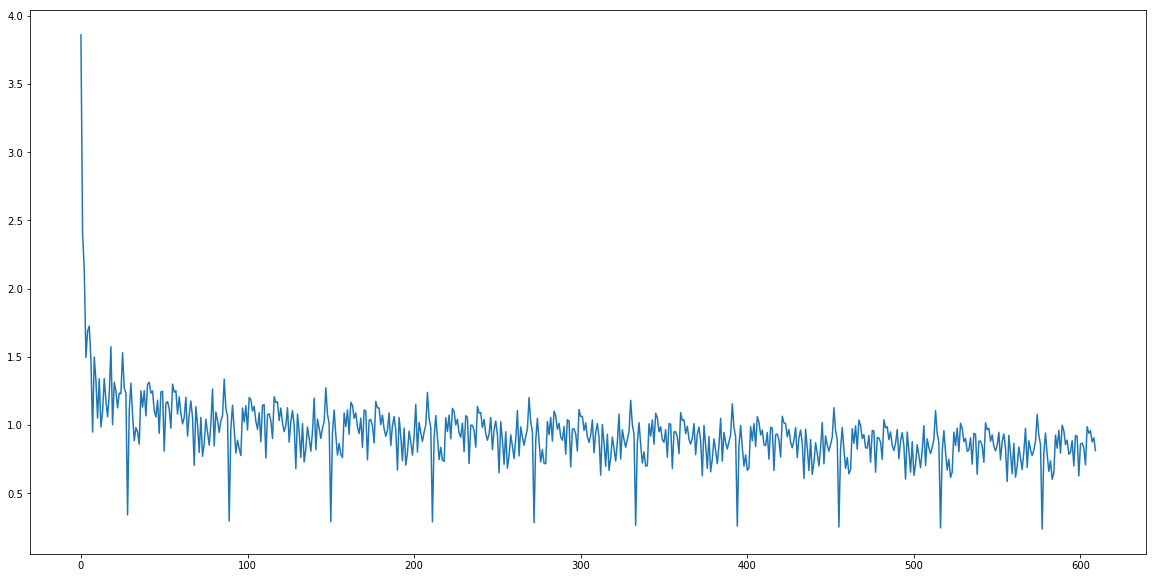

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

plt.plot(loss_track)
